In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from matplotlib import pyplot



from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_recall_fscore_support, f1_score
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler

In [96]:
data = pd.read_csv('diabetic_data.csv')
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [97]:
data = data.replace('?', np.NaN)
data = data.replace('Unknown/Invalid', np.NaN)
data = data.replace('nan', np.NaN)
data = data.replace('None', np.NaN)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101763 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [98]:
#too many missing values
data.drop("weight", axis=1, inplace=True)
data.drop("medical_specialty", axis=1, inplace=True)
data.drop("A1Cresult", axis=1, inplace=True)
data.drop("max_glu_serum", axis=1, inplace=True)

#not relevant
data.drop("payer_code", axis=1, inplace=True)
data.drop("admission_source_id", axis=1, inplace=True)
data.drop("discharge_disposition_id", axis=1, inplace=True)
data.drop("admission_type_id", axis=1, inplace=True)
data.drop("encounter_id", axis=1, inplace=True)
data.drop("patient_nbr", axis=1, inplace=True)
data.drop("diag_1", axis=1, inplace=True)
data.drop("diag_2", axis=1, inplace=True)
data.drop("diag_3", axis=1, inplace=True)

#only one unique value
data.drop("examide", axis=1, inplace=True)
data.drop("citoglipton", axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 35 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      99493 non-null   object
 1   gender                    101763 non-null  object
 2   age                       101766 non-null  object
 3   time_in_hospital          101766 non-null  int64 
 4   num_lab_procedures        101766 non-null  int64 
 5   num_procedures            101766 non-null  int64 
 6   num_medications           101766 non-null  int64 
 7   number_outpatient         101766 non-null  int64 
 8   number_emergency          101766 non-null  int64 
 9   number_inpatient          101766 non-null  int64 
 10  number_diagnoses          101766 non-null  int64 
 11  metformin                 101766 non-null  object
 12  repaglinide               101766 non-null  object
 13  nateglinide               101766 non-null  object
 14  chlo

In [99]:
#Missing values
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99492 entries, 0 to 101765
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      99492 non-null  object
 1   gender                    99492 non-null  object
 2   age                       99492 non-null  object
 3   time_in_hospital          99492 non-null  int64 
 4   num_lab_procedures        99492 non-null  int64 
 5   num_procedures            99492 non-null  int64 
 6   num_medications           99492 non-null  int64 
 7   number_outpatient         99492 non-null  int64 
 8   number_emergency          99492 non-null  int64 
 9   number_inpatient          99492 non-null  int64 
 10  number_diagnoses          99492 non-null  int64 
 11  metformin                 99492 non-null  object
 12  repaglinide               99492 non-null  object
 13  nateglinide               99492 non-null  object
 14  chlorpropamide       

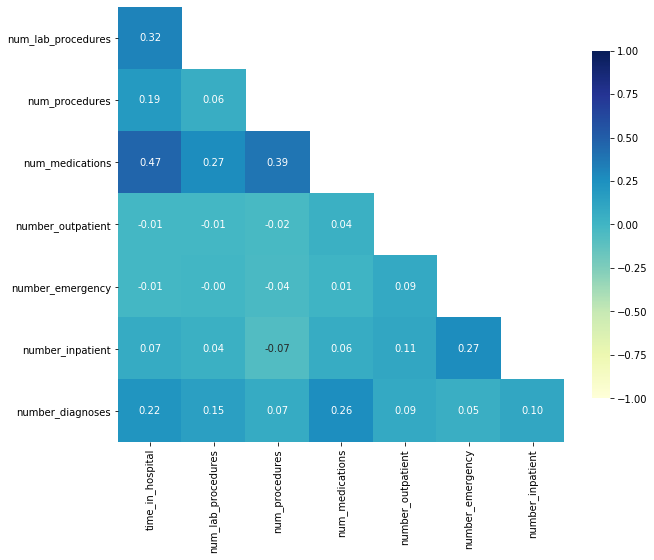

In [100]:
#Correlation matrix
df_corr = data.corr()
fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='YlGnBu', vmin=-1, vmax=1, cbar_kws={"shrink": .8})
plt.yticks(rotation=0)
plt.show()

In [101]:
#Our target
#data["diabetesMed"].replace({"No": 0, "Yes": 1}, inplace=True)

In [118]:
for i in categ:
    print(i)

race
gender
age
metformin
repaglinide
nateglinide
chlorpropamide
glimepiride
acetohexamide
glipizide
glyburide
tolbutamide
pioglitazone
rosiglitazone
acarbose
miglitol
troglitazone
tolazamide
insulin
glyburide-metformin
glipizide-metformin
glimepiride-pioglitazone
metformin-rosiglitazone
metformin-pioglitazone
change
diabetesMed
readmitted


In [124]:
#Unique values for categorials
data[num].describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,99492.000000,99492.000000,99492.000000,99492.000000,99492.000000,99492.000000,99492.000000,99492.000000
mean,4.398454,43.072971,1.340540,16.026545,0.373357,0.201343,0.643107,7.439251
std,2.986972,19.695587,1.703686,8.119809,1.276805,0.939981,1.271370,1.926043
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [122]:
for i in num:
    print(i)

time_in_hospital
num_lab_procedures
num_procedures
num_medications
number_outpatient
number_emergency
number_inpatient
number_diagnoses


In [125]:
#Unique values for categorials
categ = []
for i in data.columns:
    if data[i].dtype == object:
        categ.append(i)

for i in categ:
    print(i, data[i].unique()) 

race ['Caucasian' 'AfricanAmerican' 'Other' 'Asian' 'Hispanic']
gender ['Female' 'Male']
age ['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
metformin ['No' 'Steady' 'Up' 'Down']
repaglinide ['No' 'Up' 'Steady' 'Down']
nateglinide ['No' 'Steady' 'Down' 'Up']
chlorpropamide ['No' 'Steady' 'Down' 'Up']
glimepiride ['No' 'Steady' 'Down' 'Up']
acetohexamide ['No' 'Steady']
glipizide ['No' 'Steady' 'Up' 'Down']
glyburide ['No' 'Steady' 'Up' 'Down']
tolbutamide ['No' 'Steady']
pioglitazone ['No' 'Steady' 'Up' 'Down']
rosiglitazone ['No' 'Steady' 'Up' 'Down']
acarbose ['No' 'Steady' 'Up' 'Down']
miglitol ['No' 'Steady' 'Down' 'Up']
troglitazone ['No' 'Steady']
tolazamide ['No' 'Steady' 'Up']
insulin ['No' 'Up' 'Steady' 'Down']
glyburide-metformin ['No' 'Steady' 'Down' 'Up']
glipizide-metformin ['No' 'Steady']
glimepiride-pioglitazone ['No' 'Steady']
metformin-rosiglitazone ['No']
metformin-pioglitazone ['No' 'Steady']
change ['No' 'Ch']
d

In [103]:
yes = data[data['diabetesMed'] == "Yes"]
no = data[data['diabetesMed'] == "No"]
print('yes:', yes.shape)
print('no:', no.shape)

yes: (76491, 35)
no: (23001, 35)


In [104]:
data.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,99492.000000,99492.000000,99492.000000,99492.000000,99492.000000,99492.000000,99492.000000,99492.000000
mean,4.398454,43.072971,1.340540,16.026545,0.373357,0.201343,0.643107,7.439251
std,2.986972,19.695587,1.703686,8.119809,1.276805,0.939981,1.271370,1.926043
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [ ]:

#data["change"].replace({"No": 0, "Ch": 1}, inplace=True)
#data["glimepiride-pioglitazone"].replace({"No": 0, "Steady": 1}, inplace=True)
#data["metformin-rosiglitazone"].replace({"No": 0, "Steady": 1}, inplace=True)
#data["metformin-pioglitazone"].replace({"No": 0, "Steady": 1}, inplace=True)
#data["glipizide-metformin"].replace({"No": 0, "Steady": 1}, inplace=True)
#data["troglitazone"].replace({"No": 0, "Steady": 1}, inplace=True)
#data["acetohexamide"].replace({"No": 0, "Steady": 1}, inplace=True)
#data["tolbutamide"].replace({"No": 0, "Steady": 1}, inplace=True) 




In [105]:
cat = data[categ]

In [106]:
cat.head()

,race,gender,age,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),No,No,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),No,No,No,No,No,No,No,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),No,No,No,No,No,No,Steady,...,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),No,No,No,No,No,No,No,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),No,No,No,No,No,No,Steady,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [107]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [108]:
X = data.loc[:, data.columns != 'diabetesMed']
y = data["diabetesMed"]
X

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,readmitted
0,Caucasian,Female,[0-10),1,41,0,1,0,0,0,...,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),3,59,0,18,0,0,0,...,No,No,Up,No,No,No,No,No,Ch,>30
2,AfricanAmerican,Female,[20-30),2,11,5,13,2,0,1,...,No,No,No,No,No,No,No,No,No,NO
3,Caucasian,Male,[30-40),2,44,1,16,0,0,0,...,No,No,Up,No,No,No,No,No,Ch,NO
4,Caucasian,Male,[40-50),1,51,0,8,0,0,0,...,No,No,Steady,No,No,No,No,No,Ch,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,[70-80),3,51,0,16,0,0,0,...,No,No,Down,No,No,No,No,No,Ch,>30
101762,AfricanAmerican,Female,[80-90),5,33,3,18,0,0,1,...,No,No,Steady,No,No,No,No,No,No,NO
101763,Caucasian,Male,[70-80),1,53,0,9,1,0,0,...,No,No,Down,No,No,No,No,No,Ch,NO
101764,Caucasian,Female,[80-90),10,45,2,21,0,0,1,...,No,No,Up,No,No,No,No,No,Ch,NO


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
encoder_df = pd.DataFrame(encoder.fit_transform(df[['team']]).toarray())

In [68]:
X_train.iloc[81]

race                        AfricanAmerican
gender                               Female
age                                 [50-60)
time_in_hospital                          2
num_lab_procedures                       31
num_procedures                            2
num_medications                          13
number_outpatient                         0
number_emergency                          0
number_inpatient                          2
number_diagnoses                          4
metformin                                No
repaglinide                              No
nateglinide                              No
chlorpropamide                           No
glimepiride                              No
acetohexamide                            No
glipizide                                No
glyburide                                No
tolbutamide                              No
pioglitazone                             No
rosiglitazone                            No
acarbose                        

In [70]:
X = data.loc[:, data.columns != 'diabetesMed']
y = data["diabetesMed"]
# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
# one-hot encode input variables
onehot_encoder = OneHotEncoder(handle_unknown='ignore')
onehot_encoder.fit(X_train)
X_train = onehot_encoder.transform(X_train)
X_test = onehot_encoder.transform(X_test)
# ordinal encode target variable


<69644x404 sparse matrix of type '<class 'numpy.float64'>'
	with 2367896 stored elements in Compressed Sparse Row format>

In [74]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
# define the model
model = RandomForestClassifier()
# fit on the training set
model.fit(X_train, y_train)
# predict on test set
yhat = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 99.98


In [109]:
model_pipeline = []
model_pipeline.append(LogisticRegression(solver='liblinear'))
#model_pipeline.append(SVC(probability=True))
#model_pipeline.append(KNeighborsClassifier())
#model_pipeline.append(DecisionTreeClassifier())
#model_pipeline.append(RandomForestClassifier())
#model_pipeline.append(GaussianNB())
#model_pipeline.append(XGBClassifier())

def train_and_evaluate(model, train, train_y, test, test_y, eq=None, train_model=True, threshold=0.5):
    r=[]
    a=[]
    auc=[]
    for i in range(3):
        if train_model:
            model.fit(train, train_y)

        results = model.predict_proba(test)
        proba = results[:,1]
        results = (results[:,1] > threshold).astype(int)


        cm=confusion_matrix(test_y, results)

        acc=(cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][1]+cm[1][0])
        roc=roc_auc_score(test_y, proba)
        recall=precision_recall_fscore_support(test_y, results)[1][1]
        a.append(acc)
        r.append(recall)
        auc.append(roc)
    #print(classification_report(test_y, results))
    print('Recall :', str(round(sum(r)/3,4)), '; Accuracy :',str(round(sum(a)/3,4)),'; ROC AUC :',str(round(sum(auc)/3,4)))    
    return proba


def training_models (model_pipeline, X_train, y_train, X_test, y_test):
    
    model_names = ['Logistic Regression']
    
    for i in range(len(model_pipeline)):
        if model_names[i] == 'Logistic Regression':
            print(model_names[i])
            lg_pr=train_and_evaluate(model_pipeline[i], X_train, y_train, X_test, y_test)
            
        else:
            print(model_names[i])
            train_and_evaluate(model_pipeline[i], X_train, y_train, X_test, y_test)

In [110]:
X = data.loc[:, data.columns != 'diabetesMed']
y = data["diabetesMed"]
# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
# one-hot encode input variables
onehot_encoder = OneHotEncoder(handle_unknown='ignore')
onehot_encoder.fit(X_train)
X_train = onehot_encoder.transform(X_train)
X_test = onehot_encoder.transform(X_test)
# ordinal encode target variable
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

In [111]:
#undersampling
rus = RandomUnderSampler(random_state=42, replacement=True)
x_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

print('original dataset shape:', y_train.shape)
print('Resample dataset shape', y_train_rus.shape)

training_models (model_pipeline, x_train_rus, y_train_rus, X_test, y_test)

original dataset shape: (69644,)
Resample dataset shape (32022,)
Logistic Regression
Recall : 0.9986 ; Accuracy : 0.9989 ; ROC AUC : 0.9998


In [112]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
x_train_rus, y_train_rus = ros.fit_resample(X_train, y_train)

print('randomoversampling')

training_models (model_pipeline, x_train_rus, y_train_rus, X_test, y_test)

randomoversampling
Logistic Regression
Recall : 0.9996 ; Accuracy : 0.9997 ; ROC AUC : 1.0


In [113]:
from imblearn.under_sampling import TomekLinks

tl_maj = TomekLinks(sampling_strategy='majority')

x_train_rus, y_train_rus = tl_maj.fit_resample(X_train, y_train)


print('tomeklink')

training_models (model_pipeline, x_train_rus, y_train_rus, X_test, y_test)

tomeklink
Logistic Regression
Recall : 0.9998 ; Accuracy : 0.9998 ; ROC AUC : 1.0


In [115]:
from imblearn.under_sampling import NearMiss


nearmiss_3 = NearMiss(version=3)

x_train_rus, y_train_rus = nearmiss_3.fit_resample(X_train, y_train)


print('tomeklink')

training_models (model_pipeline, x_train_rus, y_train_rus, X_test, y_test)

/Users/juliasulstarova/anaconda3/lib/python3.6/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:176: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"


tomeklink
Logistic Regression
Recall : 0.999 ; Accuracy : 0.9993 ; ROC AUC : 1.0


In [116]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()

x_train_rus, y_train_rus = smote.fit_resample(X_train, y_train)


print('tomeklink')

training_models (model_pipeline, x_train_rus, y_train_rus, X_test, y_test)

tomeklink
Logistic Regression
Recall : 0.9996 ; Accuracy : 0.9997 ; ROC AUC : 1.0
